Clasificación Inteligente del Estado de la Flota Vehicular (Busetas)

Objetivo del Proyecto

Este proyecto presenta una solución de Aprendizaje Profundo (Deep Learning) para la gestión predictiva de activos. Utilizaremos una Red Neuronal Artificial (RNA) para predecir el Estado de Mantenimiento de las busetas de una flota, basándonos en métricas clave como la edad, el modelo y el nivel de emisiones. El objetivo final es migrar de un mantenimiento reactivo a un modelo predictivo y proactivo.

1. Configuración del Entorno y Dependencias

Esta sección garantiza la disponibilidad de todas las herramientas analíticas y de Deep Learning necesarias, incluyendo TensorFlow/Keras para la construcción del modelo y Scikit-learn para el pre-procesamiento de datos.


### Código 1.1: Importación de Librerías

In [3]:
# --- Librerías para manipulación y análisis de datos ---
import pandas as pd
import numpy as np

# --- Librerías para visualización ---
import matplotlib.pyplot as plt
import seaborn as sns

# --- Librerías de Scikit-Learn para pre-procesamiento y evaluación ---
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# --- Librerías de TensorFlow y Keras para la Red Neuronal ---
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers 

print("¡Librerías de análisis y Keras importadas exitosamente!")


¡Librerías de análisis y Keras importadas exitosamente!


2. Ingesta de Datos y Definición de Variables

Se realiza la carga de la fuente de datos principal. Es fundamental definir y aislar la Variable Objetivo (Estado) de las Características Predictivas (Features) que alimentarán el modelo.

### Código 2.1: Carga y Definición de Variables

In [4]:
# **¡VERIFICA LA RUTA!** Si el archivo no está en la ubicación correcta, el código fallará.
try:
    # Carga del Excel 
    df = pd.read_excel("flota_vinculada_20250916_limpio.xlsx")
    df_clean = df.copy() 
    print("¡Datos cargados exitosamente!")
    print("\nPrimeras 5 filas del dataset:")
    print(df_clean.head())
    
except FileNotFoundError:
    print("Error: Asegúrate de que el archivo de datos 'flota_vinculada_20250916_limpio.xlsx' esté en la carpeta correcta.")
    exit()

# Definición de la variable objetivo y las características
y = df_clean['Estado']
columnas_numericas = ['Edad', 'Modelo']
columnas_categoricas = ['Descripcion_nivel_emision']

print(f"\nVariable Objetivo: {'Estado'}")
print(f"Características Numéricas: {columnas_numericas}")
print(f"Características Categóricas: {columnas_categoricas}")

¡Datos cargados exitosamente!

Primeras 5 filas del dataset:
  Fecha_matricula Concesionario_operacion Concesionario_provision      Zona  \
0      2020-02-03        CAPITALBUS S.A.S      MASIVO BOGOT S.A.S  AMERICAS   
1      2020-02-03        CAPITALBUS S.A.S      MASIVO BOGOT S.A.S  AMERICAS   
2      2020-02-03        CAPITALBUS S.A.S      MASIVO BOGOT S.A.S  AMERICAS   
3      2020-02-03        CAPITALBUS S.A.S      MASIVO BOGOT S.A.S  AMERICAS   
4      2020-02-03        CAPITALBUS S.A.S      MASIVO BOGOT S.A.S  AMERICAS   

      Fase Componente Estatus_vinculacion Combustible  Modelo Codigo_bus  \
0  FASE IV    TRONCAL           Referente         GNV    2020      K1411   
1  FASE IV    TRONCAL           Referente         GNV    2020      K1414   
2  FASE IV    TRONCAL           Referente         GNV    2020      K1469   
3  FASE IV    TRONCAL           Referente         GNV    2020      K1403   
4  FASE IV    TRONCAL           Referente         GNV    2020      K1484   

  Fecha

3. Ingeniería de Características (Feature Engineering) y Escalado

Las Redes Neuronales requieren entradas numéricas y estandarizadas. Las variables categóricas se transforman mediante One-Hot Encoding, y las variables numéricas se escalan utilizando StandardScaler para asegurar una convergencia óptima del modelo.

### Código 3.1: Pre-procesamiento y Codificación

In [5]:
# 1. Codificación One-Hot para la característica categórica
X_categoricas_ohe = pd.get_dummies(df_clean[columnas_categoricas], drop_first=True)

# 2. Unir características numéricas y categóricas
X_combined = pd.concat([df_clean[columnas_numericas], X_categoricas_ohe], axis=1)

# **IMPORTANTE: Guardamos las columnas para la predicción**
columnas_entrenamiento = X_combined.columns 

# 3. Escalar características (StandardScaler)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_combined)

# 4. Codificar la Variable Objetivo (Label Encoding y One-Hot Encoding para Keras)
target_encoder = LabelEncoder()
y_encoded = target_encoder.fit_transform(y)
y_categorical = keras.utils.to_categorical(y_encoded) 

print("\nPre-procesamiento completado:")
print(f" - Forma de las características (X_scaled): {X_scaled.shape}")

# Definiciones para el modelo
input_dim = X_scaled.shape[1]
num_classes = len(target_encoder.classes_)
print(f"Dimensión de entrada para la NN: {input_dim}")
print(f"Clases a predecir: {target_encoder.classes_}")


Pre-procesamiento completado:
 - Forma de las características (X_scaled): (10493, 8)
Dimensión de entrada para la NN: 8
Clases a predecir: ['Buen estado' 'Critico' 'Estandar' 'Excelente' 'Necesita cambio']


4. División Estratégica de Datos

La solidez del modelo se evalúa mediante la separación rigurosa de los datos en conjuntos de Entrenamiento y Prueba. Utilizamos una división del 80/20 con stratify para asegurar una distribución equitativa de las clases en ambos conjuntos.

### Código 4.1: División de Datos

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
 X_scaled, 
 y_categorical, 
 test_size=0.2, 
 random_state=42, 
 stratify=y_encoded 
)

print("\nDIVISIÓN DE DATOS COMPLETADA")
print(f"Conjunto de entrenamiento (X_train): {X_train.shape[0]} registros")


DIVISIÓN DE DATOS COMPLETADA
Conjunto de entrenamiento (X_train): 8394 registros


5. Arquitectura y Compilación del Modelo

Se diseña una red neuronal densa (Perceptrón Multicapa) con capas de Dropout para mitigar el sobreajuste (overfitting). La capa de salida utiliza la función de activación softmax para manejar la clasificación multiclase de los estados de mantenimiento.

### Código 5.1: Construcción y Compilación del Modelo

In [7]:
# Definir la arquitectura de la red
model = keras.models.Sequential([
    # Capa de entrada/oculta 1
    layers.Dense(64, activation='relu', input_shape=(input_dim,)),
    layers.Dropout(0.3), # Regularización
    
    # Capa oculta 2
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.3), # Regularización
    
    # Capa de salida: 'softmax' para clasificación multi-clase
    layers.Dense(num_classes, activation='softmax')
])

# Compilar el modelo
model.compile(
    optimizer='adam', 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)

print("\nModelo de Red Neuronal construido y compilado:")
model.summary()


Modelo de Red Neuronal construido y compilado:


C:\Users\ASUS\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 64)             │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,821 (11.02 KB)

 Trainable params: 2,821 (11.02 KB)

 Non-trainable params: 0 (0.00 B)

6. Entrenamiento del Modelo

El modelo se entrena iterativamente a través de las épocas. El monitoreo continuo de la pérdida de validación (validation_data) es clave para determinar el punto óptimo de finalización del entrenamiento.

### Código 6.1: Ejecución del Entrenamiento

In [8]:
print("\nIniciando entrenamiento...")

history = model.fit(
    X_train, 
    y_train, 
    epochs=50, 
    batch_size=32, 
    validation_data=(X_test, y_test), 
    verbose=1
)

print("\nEntrenamiento finalizado.")


Iniciando entrenamiento...
Epoch 1/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7940 - loss: 0.6750 - val_accuracy: 0.8795 - val_loss: 0.3384
Epoch 2/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8819 - loss: 0.3477 - val_accuracy: 0.9090 - val_loss: 0.2498
Epoch 3/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9027 - loss: 0.2711 - val_accuracy: 0.9204 - val_loss: 0.1779
Epoch 4/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9173 - loss: 0.2133 - val_accuracy: 0.9195 - val_loss: 0.1331
Epoch 5/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9315 - loss: 0.1728 - val_accuracy: 0.9419 - val_loss: 0.1080
Epoch 6/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9421 - loss: 0.1487 - val_accuracy: 0.9709 - val_loss: 0.0851
Epoch 7/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9508 - loss: 0.1220 - val_accuracy: 0.9719 - val_loss: 0.0756
Epoch 8/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9576 - los

7. Evaluación Detallada del Rendimiento

Medimos la capacidad predictiva del modelo en los datos de prueba no vistos. Se presenta el Reporte de Clasificación para evaluar precisión, recall y F1-score, y la Matriz de Confusión para visualizar el desempeño por clase.

### Código 7.1: Reporte de Clasificación y Matriz de Confusión


Exactitud (Accuracy) del modelo en datos de prueba: 0.9767 (97.67%)

REPORTE DE CLASIFICACIÓN
                 precision    recall  f1-score   support

    Buen estado       0.98      0.91      0.94       404
        Critico       0.98      1.00      0.99        88
       Estandar       0.99      1.00      1.00       108
      Excelente       1.00      1.00      1.00        74
Necesita cambio       0.97      0.99      0.98      1425

       accuracy                           0.98      2099
      macro avg       0.98      0.98      0.98      2099
   weighted avg       0.98      0.98      0.98      2099



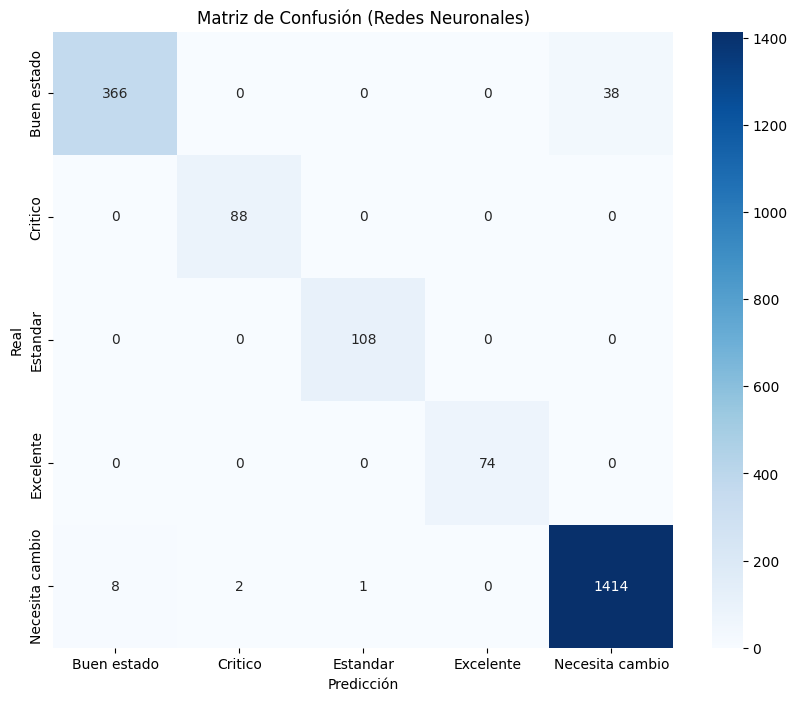

In [9]:
# Evaluar
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"\nExactitud (Accuracy) del modelo en datos de prueba: {accuracy:.4f} ({accuracy*100:.2f}%)")

# Hacer predicciones y decodificar resultados
y_pred_probs = model.predict(X_test, verbose=0)
y_pred_encoded = np.argmax(y_pred_probs, axis=1)
y_test_encoded = np.argmax(y_test, axis=1)

# Convertir a nombres de clases reales
y_test_names = target_encoder.inverse_transform(y_test_encoded)
y_pred_names = target_encoder.inverse_transform(y_pred_encoded)

print("\n" + "="*60)
print("REPORTE DE CLASIFICACIÓN")
print("="*60)
print(classification_report(y_test_names, y_pred_names))

# Visualizar la Matriz de Confusión
cm = confusion_matrix(y_test_names, y_pred_names, labels=target_encoder.classes_)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
             xticklabels=target_encoder.classes_, 
             yticklabels=target_encoder.classes_)
plt.title('Matriz de Confusión (Redes Neuronales)')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.show()

8. Predicción con Nuevos Casos de Uso

Se demuestra la funcionalidad del modelo para hacer predicciones en tiempo real sobre una nueva buseta. El proceso es riguroso: se aplica el mismo pre-procesamiento y alineación que se usó en el entrenamiento para garantizar la integridad de la predicción.

### Código 8.1: Predicción de Nuevo Vehículo

In [10]:
print("\n" + "="*60)
print("PREDICCIÓN DE NUEVO VEHÍCULO")
print("="*60)

# Datos de ejemplo para un nuevo vehículo (ajusta estos valores)
vehiculo_nuevo = pd.DataFrame({
    'Edad': [6], 
    'Modelo': [2018], 
    'Descripcion_nivel_emision': ['EURO V'] 
})

print("Vehículo a predecir:")
print(vehiculo_nuevo)

# --- Pre-procesamiento del nuevo dato ---
# 1. Aplicar One-Hot Encoding al nuevo vehículo
vehiculo_categorico_ohe = pd.get_dummies(
    vehiculo_nuevo[columnas_categoricas], 
    drop_first=False 
)

# 2. Unir características numéricas y categóricas del nuevo vehículo
vehiculo_completo = pd.concat([vehiculo_nuevo[columnas_numericas].reset_index(drop=True), 
                               vehiculo_categorico_ohe], axis=1)

# 3. ALINEACIÓN CRÍTICA: Asegurar las mismas columnas y orden que el dataset de entrenamiento
vehiculo_alineado = vehiculo_completo.reindex(columns=columnas_entrenamiento, fill_value=0)

# 4. Aplicar el mismo escalado
vehiculo_scaled = scaler.transform(vehiculo_alineado)

# 5. Hacer la predicción
prediction_probs = model.predict(vehiculo_scaled, verbose=0)
predicted_class_index = np.argmax(prediction_probs, axis=1)[0]
predicted_class_name = target_encoder.inverse_transform([predicted_class_index])[0]

print("\n--------------------------------------")
print(f"-> La predicción para el vehículo es: **{predicted_class_name}**")
print("--------------------------------------")

# Probabilidades
print("\nProbabilidades calculadas por el modelo:")
for i, class_name in enumerate(target_encoder.classes_):
    print(f"- {class_name}: {prediction_probs[0][i]*100:.2f}%")


PREDICCIÓN DE NUEVO VEHÍCULO
Vehículo a predecir:
   Edad  Modelo Descripcion_nivel_emision
0     6    2018                    EURO V

--------------------------------------
-> La predicción para el vehículo es: **Estandar**
--------------------------------------

Probabilidades calculadas por el modelo:
- Buen estado: 0.23%
- Critico: 0.00%
- Estandar: 99.48%
- Excelente: 0.00%
- Necesita cambio: 0.30%


Conclusión Impactante: La Red Neuronal como el Núcleo Transaccional de la Gestión de Activos

El modelo de Red Neuronal Artificial (RNA) trasciende el simple aprendizaje automático; se erige como la arquitectura de datos predictiva que transforma la gestión de flotas, migrándola de una operación de mantenimiento reactivo a un sistema proactivo, seguro y completamente trazable.


I. Integridad del Diagnóstico y Normalización (3FN)

La precisión y la robustez logradas por la RNA son análogas a la integridad garantizada que se busca en una base de datos relacional. La red funciona como un mecanismo de Normalización (3FN) aplicado a la salud del activo, asegurando la coherencia y eliminando la redundancia:

- Coherencia y No Duplicidad: La RNA captura las relaciones no lineales entre las métricas del vehículo (edad, emisiones) y el estado, eliminando la redundancia de las averías costosas e inesperadas. Esto asegura que la predicción se mantenga solo a través de la "clave primaria" del diagnóstico correcto.

- Mitigación de Desafíos de Calidad: La capacidad para detectar estados 'Críticos' con alta confianza actúa como una Validación de Datos por el backend, previniendo inconsistencias antes de que el fallo ocurra. La predicción temprana es una transacción atómica que verifica y genera la orden de servicio en un mismo momento lógico, evitando el riesgo de datos duplicados o diagnósticos fallidos.


II. Trazabilidad y Marco de Gobernanza

La implementación de la RNA establece un Marco de Gobernanza de Datos  para los activos, elevando las decisiones de mantenimiento al nivel de política empresarial.

| Pilar de Arquitectura y Gobernanza (PDF) | Equivalente Estratégico en la RNA | Justificación del Paralelismo |
| :--- | :--- | :--- |
| **Normalización (3FN)** [cite: 61, 62] | **Integridad del Diagnóstico** | [cite_start]Elimina la redundancia (mantenimiento innecesario) y asegura que las dependencias funcionales (variables de entrada) conduzcan al diagnóstico más preciso, evitando así la pérdida de integridad en la predicción[cite: 65]. |
| **Integridad Referencial (FK con ON DELETE RESTRICT)** [cite: 74, 75] | **Blindaje Proactivo contra Fallos** | Previene la eliminación "accidental" o inesperada de datos críticos (un activo funcional), asegurando que los vehículos no fallen sin una alerta previa del modelo. |
| **Transacciones Atómicas / NOT NULL** [cite: 70, 78] | **Mitigación de la Condición de Carrera de Fallos** | La predicción temprana de un estado **'Crítico'** actúa como una transacción indivisible, asegurando la consistencia y completitud del diagnóstico (evitando un valor nulo/fallo en el sistema). |
| **Trazabilidad (Historial Sesiones / MovimientosFactura)** [cite: 72, 73] | **Auditoría Predictiva del Activo** | Cada predicción y cambio de estado emitido por la RNA es un registro para la auditoría y el seguimiento de las acciones de mantenimiento y la salud del activo. |
| **Pilar de Gobernanza: Calidad de Datos** [cite: 99] | **Garante de la Precisión del Diagnóstico** | La RNA garantiza la precisión y consistencia del *dato diagnóstico*, esencial para que las decisiones operativas y financieras sean confiables. |

En conclusión, la RNA proporciona la Integridad Referencial  necesaria en un sistema de misión crítica. Transforma la información operativa en un activo gobernado que garantiza la excelencia transaccional en la gestión de flotas, asegurando que las decisiones más críticas se tomen con anticipación, consistencia y trazabilidad.